In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime, os, glob, json, string, inspect, emcee
from scipy.stats import median_abs_deviation, poisson
from matplotlib.patches import Circle, Ellipse
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from astropy.io import ascii, fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from PyDynamic import interp1d_unc
from astropy.table import Table
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
import pickle as p

## Load in the Data

In [6]:
# MeerKAT Flux Densities 
MeerKAT_isot, _ = np.load('../../analysis/meerkat/results/imfit_times.npy')
MeerKAT_times = Time(MeerKAT_isot, format='isot').mjd
MeerKAT_flux = np.load('../../analysis/meerkat/results/imfit_flux_results.npy')

# Swift-XRT spectral dictionaries -- Keys describe each entry -- 0.5 - 10.0 keV
with open('../../analysis/swift-xrt/results/fit_dict_full_Emin0.5.json') as jfile:
    spectra = json.load(jfile)
    
# 1.0 - 10.0 keV
with open('../../analysis/swift-xrt/results/fit_dict_full_Emin1.0.json') as jfile:
    spectra_1 = json.load(jfile)
    
for key in spectra.keys():
    spectra[key] = np.array(spectra[key])
spectra['tot_flux'] = spectra['flux'] + spectra['bb_flux']
spectra['tot_flux_neg'] = np.sqrt(spectra['flux_neg']**2 + spectra['bb_flux_neg']**2)
spectra['tot_flux_pos'] = np.sqrt(spectra['flux_pos']**2 + spectra['bb_flux_pos']**2)
spectra['times_mjd'] = Time(spectra['times'], format='isot').mjd
spectra['power_law_frac'] = spectra['flux']/spectra['tot_flux']
spectra['power_law_frac_neg'] = spectra['flux']/spectra['tot_flux'] * np.sqrt((spectra['flux_pos']/spectra['flux']) ** 2 + (spectra['tot_flux_pos']/spectra['tot_flux']) ** 2)
spectra['power_law_frac_pos'] = spectra['flux']/spectra['tot_flux'] * np.sqrt((spectra['flux_neg']/spectra['flux']) ** 2 + (spectra['tot_flux_neg']/spectra['tot_flux']) ** 2)
    
for key in spectra_1.keys():
    spectra_1[key] = np.array(spectra_1[key])
spectra_1['tot_flux']     = spectra_1['flux'] + spectra_1['bb_flux']
spectra_1['tot_flux_neg'] = np.sqrt(spectra_1['flux_neg']**2 + spectra_1['bb_flux_neg']**2)
spectra_1['tot_flux_pos'] = np.sqrt(spectra_1['flux_pos']**2 + spectra_1['bb_flux_pos']**2)
spectra_1['power_law_frac'] = spectra_1['flux']/spectra_1['tot_flux']
spectra_1['power_law_frac_neg'] = spectra_1['flux']/spectra_1['tot_flux'] * np.sqrt((spectra_1['flux_pos']/spectra_1['flux']) ** 2 + (spectra_1['tot_flux_pos']/spectra_1['tot_flux']) ** 2)
spectra_1['power_law_frac_pos'] = spectra_1['flux']/spectra_1['tot_flux'] * np.sqrt((spectra_1['flux_neg']/spectra_1['flux']) ** 2 + (spectra_1['tot_flux_neg']/spectra_1['tot_flux']) ** 2)
spectra_1['times_mjd'] = Time(spectra_1['times'], format='isot').mjd

# Swift-BAT and MAXI/GSC HR Ratio
HR_data = np.loadtxt('../../analysis/bat-maxi/results/HR_fits.txt')

de = np.where(HR_data[:,-1].astype(int) == 0)[0]  # Detection indexes (Both > 3-sigma)
ll  = np.where(HR_data[:,-1].astype(int) == 1)[0] # Lower-Limit (only BAT > 3-sigma)

## Plot the data

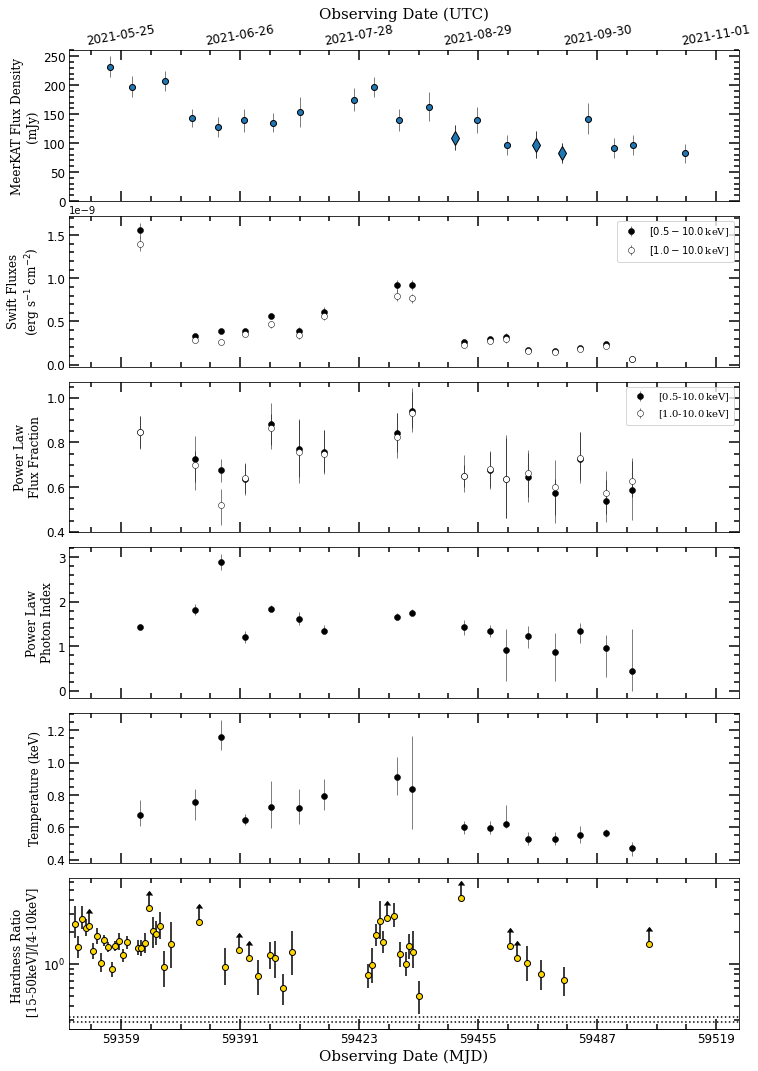

In [8]:
# Make the Plots
fig,ax = plt.subplots(6,figsize=(12,18),sharex='col',gridspec_kw={'hspace': 0.1, 'wspace': 0})

# MeerKAT Flux Density
ax[0].errorbar(Time(MeerKAT_times, format='mjd').datetime,MeerKAT_flux[0], yerr=MeerKAT_flux[1],fmt='o', mec='k', mew=1.0, ecolor='k', lw=0.5, c='C0')
ax[0].errorbar(Time(MeerKAT_times[np.where(MeerKAT_flux[0]/MeerKAT_flux[1] < 5.0)], format='mjd').datetime,MeerKAT_flux[0][np.where(MeerKAT_flux[0]/MeerKAT_flux[1] < 5.0)], yerr=MeerKAT_flux[1][np.where(MeerKAT_flux[0]/MeerKAT_flux[1] < 5.0)],fmt='d', mec='k', mew=1.0, ecolor='k', lw=0.5, c='C0', ms=10)
ax[0].set_ylabel('MeerKAT Flux Density\n(muJy)', fontsize=12,fontfamily='serif')
ax[0].set_ylim(0,260)

# Swift XRT Fluxes 
ax[1].errorbar(Time(spectra['times_mjd'], format='mjd').datetime,spectra['tot_flux'], yerr=[spectra['tot_flux_neg'],spectra['tot_flux_pos']],fmt='o', mec='k', mew=0.5, ecolor='k', lw=0.5, c='k', label='$[0.5-10.0\,$keV]')
ax[1].errorbar(Time(spectra_1['times_mjd'], format='mjd').datetime,spectra_1['tot_flux'], yerr=[spectra_1['tot_flux_neg'],spectra_1['tot_flux_pos']],fmt='o', mec='k', mew=0.5, ecolor='k', lw=0.5, c='w', label='$[1.0-10.0\,$keV]')
ax[1].set_ylabel('Swift Fluxes\n(erg s$^{-1}$ cm$^{-2}$)', fontsize=12,fontfamily='serif')
ax[1].legend(prop={'family':'serif'})

# Swift XRT Flux Ratio between BB and PWRLW
ax[2].errorbar(Time(spectra['times_mjd'], format='mjd').datetime, spectra['power_law_frac'], yerr=[spectra['power_law_frac_neg'],spectra['power_law_frac_pos']],fmt='o', mec='k', mew=0.5, ecolor='k', lw=0.5, c='k', label='[0.5-10.0$\,$keV]')
ax[2].errorbar(Time(spectra_1['times_mjd'], format='mjd').datetime, spectra_1['power_law_frac'], yerr=[spectra_1['power_law_frac_neg'],spectra_1['power_law_frac_pos']],fmt='o', mec='k', mew=0.5, ecolor='k', lw=0.5, c='w', label='[1.0-10.0$\,$keV]')
ax[2].set_ylabel('Power Law\nFlux Fraction', fontsize=12,fontfamily='serif')
ax[2].legend(prop={'family':'serif'})

ax[3].errorbar(Time(spectra_1['times_mjd'], format='mjd').datetime, spectra_1['gamma'],yerr=[spectra_1['gamma_neg'],spectra_1['gamma_pos']],fmt='o', mec='k', mew=0.5, ecolor='k', lw=0.5, c='k')
ax[3].set_ylabel('Power Law\nPhoton Index', fontsize=12,fontfamily='serif')

ax[4].errorbar(Time(spectra_1['times_mjd'], format='mjd').datetime, spectra_1['kt'],yerr=[spectra_1['kt_neg'],spectra_1['kt_pos']],fmt='o', mec='k', mew=0.5, ecolor='k', lw=0.5, c='k')
ax[4].set_ylabel(r'Temperature (keV)', fontsize=12,fontfamily='serif')

ax[5].errorbar(Time(HR_data[:,0][de], format='mjd').datetime,HR_data[:,1][de],yerr=[HR_data[:,2][de],HR_data[:,3][de]], fmt='o', c='gold', ecolor='k',mec='k')
ax[5].errorbar(Time(HR_data[:,0][ll], format='mjd').datetime,HR_data[:,1][ll],yerr=HR_data[:,1][ll]/3.0, fmt='o', c='gold',mec='k',ecolor='k',lolims=True)
ax[5].axhline(0.3204, ls=':', c='k')  
ax[5].axhline(0.2846, ls=':', c='k')  
ax[5].set_yscale('log')
ax[5].set_ylabel('Hardness Ratio \n [15-50keV]/[4-10keV]', fontsize=12,fontfamily='serif')

# Make it Pretty
for ax_i in ax:
    #ax_i.xaxis.set_minor_locator(AutoMinorLocator(3))
    ax_i.tick_params(axis='both', which='minor', direction='in',length=5,width=1.5,top=True,right=True)
    ax_i.tick_params(axis='both', which='major', direction='in',length=10,width=1.5,top=True,right=True, labelsize=12, labelbottom=False)
    ax_i.minorticks_on()
    
def plot2mjd(t):
    '''Convert from matplotlib plot date to mjd'''
    return Time(t, format="plot_date", scale='utc').mjd


def mjd2plot(mjd):print(mkat_times[0][-1])

    '''Convert from mjd to matplotlib plot'''
    return Time(mjd, format="mjd", scale='utc').plot_date

# Format primary x-axis
ax[0].set_xlabel('Observing Date (UTC)', fontsize=15, fontfamily='serif')    
ax[0].set_xlim(Time(59345, format='mjd').datetime,Time(59525, format='mjd').datetime)
ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=32))
ax[0].xaxis.set_label_position('top') 
xformatter = mdates.DateFormatter('%Y-%m-%d')
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
ax[0].tick_params(axis='x', which='major',rotation=10, labelsize=12 ,labeltop=True, labelbottom=False)

# Format secondary x-axis
mjd_ax = ax[-1].secondary_xaxis('bottom', functions=(plot2mjd, mjd2plot))
mjd_ax.set_xlabel('Observing Date (MJD)', fontsize=15, fontfamily='serif')  
mjd_ax.tick_params(which='major', direction='in', length = 0.0, width = 0.0, labelsize=12)
plt.draw()

# Extract the labels
mjd_ticks = []
labels = ax[0].get_xticklabels(which='major')
for lab in labels:
    mjd_ticks.append(lab.get_text() + 'T00:00:00')

# Line up MJD and Datetime labels 
mjd_ticks = (Time(mjd_ticks, format='isot').mjd).astype(int)
mjd_ax.set_xticks(mjd_ticks, labels = mjd_ticks)
plt.show()